# **Importation**


In [ ]:
!pip install opencv-python

In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, TensorBoard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l1_l2, l2, l1
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.optimizers import Adam

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import glob
from PIL import Image
import cv2
from tqdm import tqdm

from io import BytesIO

import imgaug.augmenters as iaa

from tensorflow.keras.applications import EfficientNetB4, EfficientNetB7



# **Fonction predict**

In [ ]:
def predictImage(url, model):
    '''Takes an image and a model
    '''
    img = load_img(url, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = img_array.reshape((-1, 224, 224, 3))
    res = model.predict(img_array)[0][0]

    if res < 0.5:
        diagnostic = "Négatif"
        prob = 1 - res
    else:
        diagnostic = "Positif"
        prob = res

    plt.imshow(array_to_img(img_array[0]))
    plt.axis("off")
    plt.title(f"{diagnostic} ({prob:.2%})")


    return  plt.show()



# **Extraction data**



In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = "/content/preprocess_img.zip"  # Modifier avec votre chemin réel

import zipfile

# Définir le chemin du fichier ZIP et le dossier de destination
zip_path = "/content/preprocess_img.zip"
extract_path = "/content/data"  # Dossier où extraire les fichiers

# Extraire le fichier ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction terminée !")


Extraction terminée !


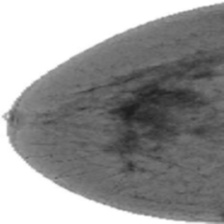

In [ ]:
load_img('/content/data/preprocess_img/test/0/crp_105_1934323665_png.rf.a1e70bb0747c86f17a76a13894e8e191.jpg')

In [ ]:
folder_path = "/content/data/preprocess_img"

train_path = os.path.join(folder_path, "train")
valid_path = os.path.join(folder_path, "valid")
test_path = os.path.join(folder_path, "test")

In [ ]:
train_dataset = image_dataset_from_directory(
    train_path,
    labels="inferred",
    label_mode="binary",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123
)

validation_dataset = image_dataset_from_directory(
    valid_path,
    labels="inferred",
    label_mode="binary",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123
)

test_dataset = image_dataset_from_directory(
    test_path,
    labels="inferred",
    label_mode="binary",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123
)

Found 3129 files belonging to 2 classes.
Found 667 files belonging to 2 classes.
Found 330 files belonging to 2 classes.


# 1 Premier model, simple sans kernel regularized

In [ ]:
model = Sequential()

model.add(layers.Input((224, 224, 3)))
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="same"))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same"))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same"))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation="relu"))

model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 56, 56, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │       6,422,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,527,745 (24.90 MB)

 Trainable params: 6,527,745 (24.90 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'recall']
)

callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6223 - loss: 4.5201 - recall: 0.2455

149/149 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.6225 - loss: 4.5005 - recall: 0.2448 - val_accuracy: 0.6578 - val_loss: 0.6318 - val_recall: 0.1233
Epoch 2/30
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6813 - loss: 0.6236 - recall: 0.1895

149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6813 - loss: 0.6235 - recall: 0.1897 - val_accuracy: 0.6674 - val_loss: 0.6232 - val_recall: 0.1894
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7003 - loss: 0.5979 - recall: 0.2442 - val_accuracy: 0.6667 - val_loss: 0.6263 - val_recall: 0.2070
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7058 - loss: 0.5808 - recall: 0.2655 - val_accuracy: 0.6578 - val_loss: 0.6651 - val_recall: 0.3238
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7204 - loss: 0.5485 - recall: 0.3560 - val_accuracy: 0.6496 - val_loss: 0.6896 - val_recall: 0.2621
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7482 - loss: 0.5126 - recall: 0.3979 - val_accuracy: 0.6496 - val_loss: 0.7175 - val_recall: 0.3172
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7759 - loss: 0.4684 - recall: 0.4768 - val_accuracy: 0.6437 - val_loss: 0.7461 - val_recall: 0.2753
Epoch 8/3

In [ ]:
test_loss, test_acc, test_recall = model.evaluate(test_dataset)
print("Test accuracy:", test_acc)
print("Test recall:", test_recall)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6057 - loss: 1.0693 - recall: 0.3975
Test accuracy: 0.601190447807312
Test recall: 0.37890625


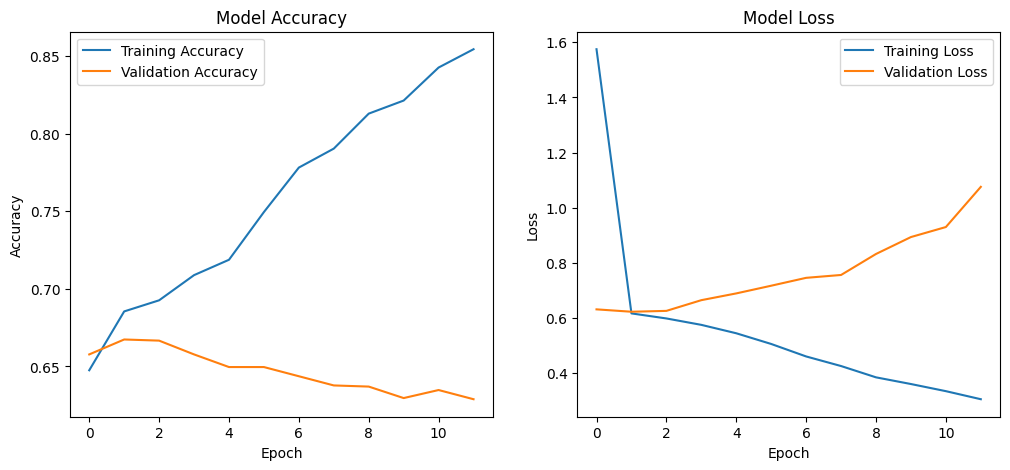

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 2 Deuxieme model, plus de couche sans regularizer

In [ ]:
model = Sequential()

model.add(layers.Input((224, 224, 3)))
model.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation="relu"))
model.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
model.add(layers.Conv2D(filters=256, kernel_size=(3,3), activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation="relu", ))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(8, activation="relu"))


model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 220, 220, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 110, 110, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 108, 108, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 106, 106, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 53, 53, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 53, 53, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 51, 51, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 49, 49, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 47, 47, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 47, 47, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 565504)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      72,384,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,799,825 (277.71 MB)

 Trainable params: 72,799,825 (277.71 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'recall']
)

callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6477 - loss: 2.1764 - recall: 0.0954

149/149 ━━━━━━━━━━━━━━━━━━━━ 25s 93ms/step - accuracy: 0.6478 - loss: 2.1685 - recall: 0.0953 - val_accuracy: 0.6704 - val_loss: 0.6333 - val_recall: 0.1189
Epoch 2/30
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6721 - loss: 0.6297 - recall: 0.1288

149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6721 - loss: 0.6296 - recall: 0.1287 - val_accuracy: 0.6719 - val_loss: 0.6188 - val_recall: 0.2467
Epoch 3/30
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6746 - loss: 0.6125 - recall: 0.1653

149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6746 - loss: 0.6125 - recall: 0.1656 - val_accuracy: 0.6830 - val_loss: 0.6201 - val_recall: 0.2159
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6739 - loss: 0.6141 - recall: 0.1775 - val_accuracy: 0.6756 - val_loss: 0.6223 - val_recall: 0.2159
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6963 - loss: 0.5904 - recall: 0.2634 - val_accuracy: 0.6533 - val_loss: 0.6349 - val_recall: 0.3304
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7023 - loss: 0.5669 - recall: 0.3019 - val_accuracy: 0.6111 - val_loss: 0.7207 - val_recall: 0.4295
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7219 - loss: 0.5367 - recall: 0.3996 - val_accuracy: 0.6326 - val_loss: 0.8697 - val_recall: 0.2974
Epoch 8/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7578 - loss: 0.5001 - recall: 0.4564 - val_accuracy: 0.6119 - val_loss: 0.8292 - val_recall: 0.3546
Epoch 9/3

In [ ]:
test_loss, test_acc, test_recall = model.evaluate(test_dataset)
print("Test accuracy:", test_acc)
print("Test recall:", test_recall)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5775 - loss: 1.4021 - recall: 0.3162
Test accuracy: 0.601190447807312
Test recall: 0.3359375


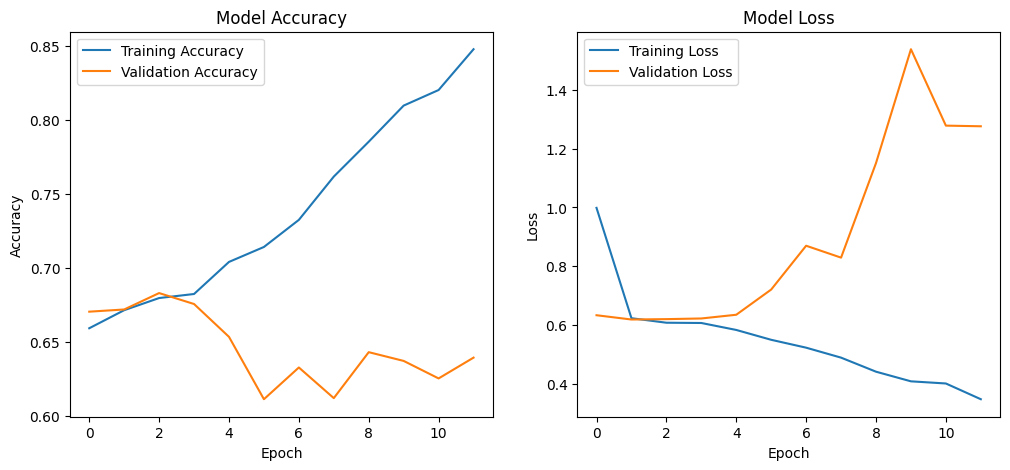

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **3 Troisième modèle avec ElasticNet, lasso, ridge**

In [ ]:
model = Sequential()

model.add(layers.Input((224, 224, 3)))
model.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation="relu", kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation="relu", kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
model.add(layers.Conv2D(filters=256, kernel_size=(3,3), activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation="relu", ))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(8, activation="relu"))


model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 220, 220, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 110, 110, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 108, 108, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 106, 106, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 53, 53, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 53, 53, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 51, 51, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 49, 49, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 47, 47, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 47, 47, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 565504)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │      72,384,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,799,825 (277.71 MB)

 Trainable params: 72,799,825 (277.71 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'recall']
)

callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6303 - loss: 2.1233 - recall: 0.1033

149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.6305 - loss: 2.1158 - recall: 0.1029 - val_accuracy: 0.6637 - val_loss: 0.6531 - val_recall: 0.0000e+00
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6662 - loss: 0.6603 - recall: 0.0017 - val_accuracy: 0.6637 - val_loss: 0.6417 - val_recall: 0.0000e+00
Epoch 3/30
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6680 - loss: 0.6393 - recall: 0.0032

149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6679 - loss: 0.6393 - recall: 0.0035 - val_accuracy: 0.6711 - val_loss: 0.6268 - val_recall: 0.1145
Epoch 4/30
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6645 - loss: 0.6335 - recall: 0.0585

149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6646 - loss: 0.6334 - recall: 0.0591 - val_accuracy: 0.6733 - val_loss: 0.6257 - val_recall: 0.1211
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6791 - loss: 0.6125 - recall: 0.1580 - val_accuracy: 0.6711 - val_loss: 0.6283 - val_recall: 0.2291
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6875 - loss: 0.5958 - recall: 0.2030 - val_accuracy: 0.6570 - val_loss: 0.6453 - val_recall: 0.2907
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6982 - loss: 0.5848 - recall: 0.2760 - val_accuracy: 0.6481 - val_loss: 0.6540 - val_recall: 0.2996
Epoch 8/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7003 - loss: 0.5728 - recall: 0.3132 - val_accuracy: 0.6481 - val_loss: 0.6690 - val_recall: 0.3084
Epoch 9/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7293 - loss: 0.5453 - recall: 0.4014 - val_accuracy: 0.6444 - val_loss: 0.7212 - val_recall: 0.2930
Epoch 10/

In [ ]:
test_loss, test_acc, test_recall = model.evaluate(test_dataset)
print("Test accuracy:", test_acc)
print("Test recall:", test_recall)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6220 - loss: 1.1784 - recall: 0.3939
Test accuracy: 0.6160714030265808
Test recall: 0.390625


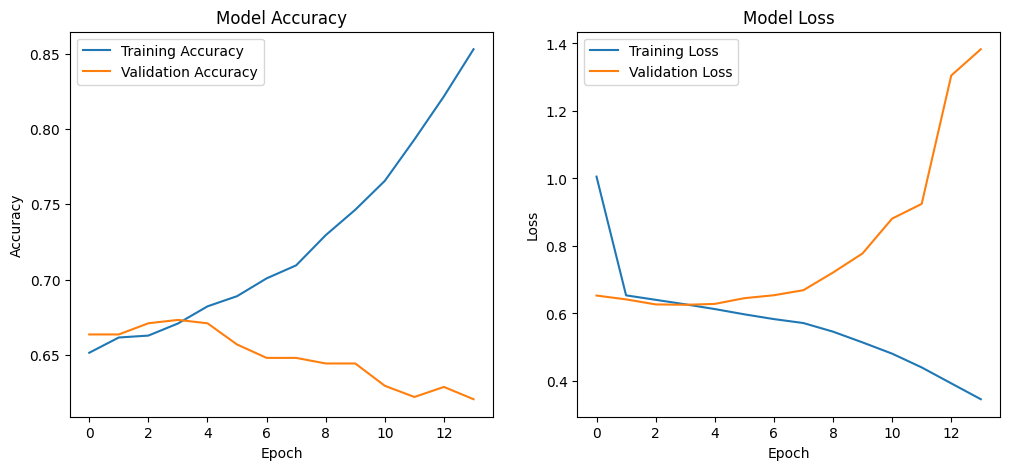

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **Exporter EfficientNetB5 et ajout de couche de neurone**

In [ ]:
# Charger EfficientNetB5
base_model = EfficientNetB5(input_shape=(224,224,3), include_top=False, weights='imagenet')
base_model.trainable = False  # On gèle le modèle pré-entraîné au début

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Ajout de couches supplémentaires pour améliorer la performance
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Réduction des dimensions
x = BatchNormalization()(x)  # ✅ Normalisation pour stabiliser l'apprentissage
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # ✅ Couche dense avec L2 Regularization ridge
x = Dropout(0.3)(x)  # ✅ Réduit le sur-apprentissage
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # ✅ Deuxième couche dense
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # ✅ Troisième couche dense
x = Dropout(0.3)(x)

output_layer = Dense(1, activation='sigmoid')(x)  # Classification binaire

# Création du modèle final
model_eff1 = Model(inputs=base_model.input, outputs=output_layer)

model_eff1.summary()

Model: "functional_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 29,735,160 (113.43 MB)

 Trainable params: 1,217,537 (4.64 MB)

 Non-trainable params: 28,517,623 (108.79 MB)

In [ ]:
model_eff1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'recall']
)

callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
]

history = model_eff1.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.6185 - loss: 10.4923 - recall: 0.2401

149/149 ━━━━━━━━━━━━━━━━━━━━ 140s 484ms/step - accuracy: 0.6186 - loss: 10.4728 - recall: 0.2400 - val_accuracy: 0.6630 - val_loss: 3.1896 - val_recall: 0.2665
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6622 - loss: 2.4105 - recall: 0.1558

149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.6622 - loss: 2.4071 - recall: 0.1557 - val_accuracy: 0.6748 - val_loss: 1.2224 - val_recall: 0.0727
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.6691 - loss: 1.0828 - recall: 0.0953 - val_accuracy: 0.6696 - val_loss: 0.8352 - val_recall: 0.1057
Epoch 4/30
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6716 - loss: 0.8008 - recall: 0.0616

149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.6715 - loss: 0.8001 - recall: 0.0620 - val_accuracy: 0.6763 - val_loss: 0.7399 - val_recall: 0.1101
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.6653 - loss: 0.7216 - recall: 0.0831 - val_accuracy: 0.6763 - val_loss: 0.6985 - val_recall: 0.1101
Epoch 6/30
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6726 - loss: 0.6847 - recall: 0.0864

149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.6725 - loss: 0.6846 - recall: 0.0863 - val_accuracy: 0.6815 - val_loss: 0.6810 - val_recall: 0.1322
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6691 - loss: 0.6750 - recall: 0.0663 - val_accuracy: 0.6748 - val_loss: 0.6732 - val_recall: 0.1542
Epoch 8/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6657 - loss: 0.6628 - recall: 0.0671 - val_accuracy: 0.6793 - val_loss: 0.6790 - val_recall: 0.2445
Epoch 9/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6647 - loss: 0.6683 - recall: 0.1088 - val_accuracy: 0.6659 - val_loss: 0.6738 - val_recall: 0.2577
Epoch 10/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6654 - loss: 0.6641 - recall: 0.1327 - val_accuracy: 0.6607 - val_loss: 0.6793 - val_recall: 0.2313
Epoch 11/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6806 - loss: 0.6686 - recall: 0.1635 - val_accuracy: 0.6704 - val_loss: 0.6695 - val_recall: 0.3084
Epoch 1

149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.6762 - loss: 0.6674 - recall: 0.2104 - val_accuracy: 0.6830 - val_loss: 0.6815 - val_recall: 0.1498
Epoch 13/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6718 - loss: 0.6631 - recall: 0.1256 - val_accuracy: 0.6667 - val_loss: 0.6758 - val_recall: 0.2335
Epoch 14/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6769 - loss: 0.6620 - recall: 0.1968 - val_accuracy: 0.6570 - val_loss: 0.6791 - val_recall: 0.2775
Epoch 15/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6858 - loss: 0.6652 - recall: 0.2378 - val_accuracy: 0.6630 - val_loss: 0.6738 - val_recall: 0.0793
Epoch 16/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6740 - loss: 0.6602 - recall: 0.1560 - val_accuracy: 0.6807 - val_loss: 0.6722 - val_recall: 0.1079
Epoch 17/30
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6776 - loss: 0.6589 - recall: 0.1693

149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.6776 - loss: 0.6588 - recall: 0.1703 - val_accuracy: 0.6852 - val_loss: 0.6718 - val_recall: 0.1652
Epoch 18/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6833 - loss: 0.6558 - recall: 0.2128 - val_accuracy: 0.6822 - val_loss: 0.6651 - val_recall: 0.1432
Epoch 19/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6833 - loss: 0.6489 - recall: 0.2316 - val_accuracy: 0.6563 - val_loss: 0.6805 - val_recall: 0.2974
Epoch 20/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6853 - loss: 0.6538 - recall: 0.2528 - val_accuracy: 0.6607 - val_loss: 0.6687 - val_recall: 0.3370
Epoch 21/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6921 - loss: 0.6472 - recall: 0.2647 - val_accuracy: 0.6659 - val_loss: 0.6802 - val_recall: 0.3304
Epoch 22/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6916 - loss: 0.6421 - recall: 0.3058 - val_accuracy: 0.6667 - val_loss: 0.6677 - val_recall: 0.2709
Epoc

149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.7022 - loss: 0.6313 - recall: 0.3046 - val_accuracy: 0.6881 - val_loss: 0.6565 - val_recall: 0.3216


In [ ]:
test_loss, test_acc, test_recall = model_eff1.evaluate(test_dataset)
print("Test accuracy:", test_acc)
print("Test recall:", test_recall)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6467 - loss: 0.6821 - recall: 0.3370
Test accuracy: 0.6309523582458496
Test recall: 0.30859375


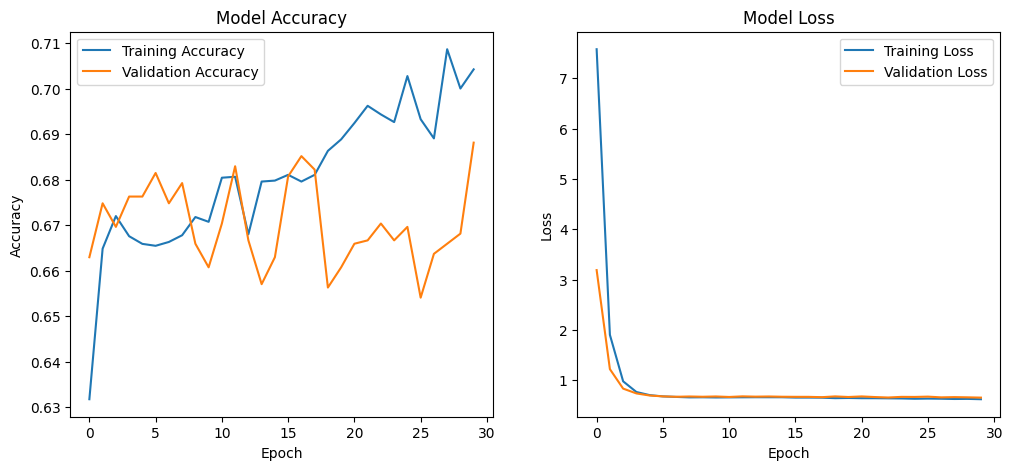

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Ajout de couches supplémentaires pour améliorer la performance
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Réduction des dimensions
x = BatchNormalization()(x)  # ✅ Normalisation pour stabiliser l'apprentissage
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # ✅ Couche dense avec L2 Regularization ridge
x = Dropout(0.3)(x)  # ✅ Réduit le sur-apprentissage
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # ✅ Deuxième couche dense
x = Dropout(0.3)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)  # ✅ Troisième couche dense
x = Dropout(0.3)(x)

output_layer = Dense(1, activation='sigmoid')(x)  # Classification binaire

# Création du modèle final
model_eff2 = Model(inputs=base_model.input, outputs=output_layer)

model_eff2.summary()

Model: "functional_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 29,087,480 (110.96 MB)

 Trainable params: 569,857 (2.17 MB)

 Non-trainable params: 28,517,623 (108.79 MB)

In [ ]:
model_eff2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'recall']
)

callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_recall', mode='max'),
    EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
]

history = model_eff2.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.5855 - loss: 6.5470 - recall: 0.2441

149/149 ━━━━━━━━━━━━━━━━━━━━ 97s 321ms/step - accuracy: 0.5858 - loss: 6.5380 - recall: 0.2439 - val_accuracy: 0.6704 - val_loss: 2.9296 - val_recall: 0.0925
Epoch 2/30
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6557 - loss: 2.3489 - recall: 0.1125

149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.6559 - loss: 2.3402 - recall: 0.1128 - val_accuracy: 0.6800 - val_loss: 1.2968 - val_recall: 0.1211
Epoch 3/30
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6703 - loss: 1.1579 - recall: 0.1301

149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.6703 - loss: 1.1558 - recall: 0.1307 - val_accuracy: 0.6719 - val_loss: 0.9015 - val_recall: 0.2048
Epoch 4/30
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6813 - loss: 0.8484 - recall: 0.1776

149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.6812 - loss: 0.8477 - recall: 0.1782 - val_accuracy: 0.6726 - val_loss: 0.7683 - val_recall: 0.2115
Epoch 5/30
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6869 - loss: 0.7411 - recall: 0.1966

149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.6868 - loss: 0.7408 - recall: 0.1967 - val_accuracy: 0.6733 - val_loss: 0.7156 - val_recall: 0.2467
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6700 - loss: 0.7020 - recall: 0.1483 - val_accuracy: 0.6704 - val_loss: 0.6918 - val_recall: 0.1211
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6799 - loss: 0.6774 - recall: 0.1680 - val_accuracy: 0.6741 - val_loss: 0.6854 - val_recall: 0.1211
Epoch 8/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6731 - loss: 0.6748 - recall: 0.1437 - val_accuracy: 0.6681 - val_loss: 0.6763 - val_recall: 0.0661
Epoch 9/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6809 - loss: 0.6629 - recall: 0.1422 - val_accuracy: 0.6622 - val_loss: 0.6709 - val_recall: 0.1388
Epoch 10/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6743 - loss: 0.6563 - recall: 0.1431 - val_accuracy: 0.6696 - val_loss: 0.6624 - val_recall: 0.1784
Epoch 11

149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.6803 - loss: 0.6592 - recall: 0.1683 - val_accuracy: 0.6689 - val_loss: 0.6733 - val_recall: 0.2996
Epoch 16/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6808 - loss: 0.6490 - recall: 0.2155 - val_accuracy: 0.6630 - val_loss: 0.6705 - val_recall: 0.2467
Epoch 17/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6900 - loss: 0.6497 - recall: 0.2359 - val_accuracy: 0.6785 - val_loss: 0.6665 - val_recall: 0.1960
Epoch 18/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6874 - loss: 0.6464 - recall: 0.2461 - val_accuracy: 0.6689 - val_loss: 0.6763 - val_recall: 0.1366
Epoch 19/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6866 - loss: 0.6404 - recall: 0.2379 - val_accuracy: 0.6637 - val_loss: 0.6710 - val_recall: 0.2489
Epoch 20/30
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6887 - loss: 0.6390 - recall: 0.2327

149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.6888 - loss: 0.6389 - recall: 0.2334 - val_accuracy: 0.6644 - val_loss: 0.6754 - val_recall: 0.3062
Epoch 21/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6872 - loss: 0.6463 - recall: 0.2444 - val_accuracy: 0.6726 - val_loss: 0.6700 - val_recall: 0.2797
Epoch 22/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6991 - loss: 0.6421 - recall: 0.2964 - val_accuracy: 0.6733 - val_loss: 0.6700 - val_recall: 0.1894
Epoch 23/30
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6933 - loss: 0.6363 - recall: 0.2737

149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.6933 - loss: 0.6363 - recall: 0.2738 - val_accuracy: 0.6600 - val_loss: 0.6658 - val_recall: 0.3150
Epoch 24/30
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7003 - loss: 0.6316 - recall: 0.2982

149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7004 - loss: 0.6315 - recall: 0.2987 - val_accuracy: 0.6674 - val_loss: 0.6706 - val_recall: 0.3414
Epoch 25/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6997 - loss: 0.6371 - recall: 0.3558 - val_accuracy: 0.6607 - val_loss: 0.6656 - val_recall: 0.2731
Epoch 26/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6980 - loss: 0.6318 - recall: 0.3056 - val_accuracy: 0.6704 - val_loss: 0.6700 - val_recall: 0.1586
Epoch 26: early stopping


In [ ]:
test_loss, test_acc, test_recall = model_eff2.evaluate(test_dataset)
print("Test accuracy:", test_acc)
print("Test recall:", test_recall)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6383 - loss: 0.6880 - recall: 0.1705
Test accuracy: 0.6190476417541504
Test recall: 0.1640625


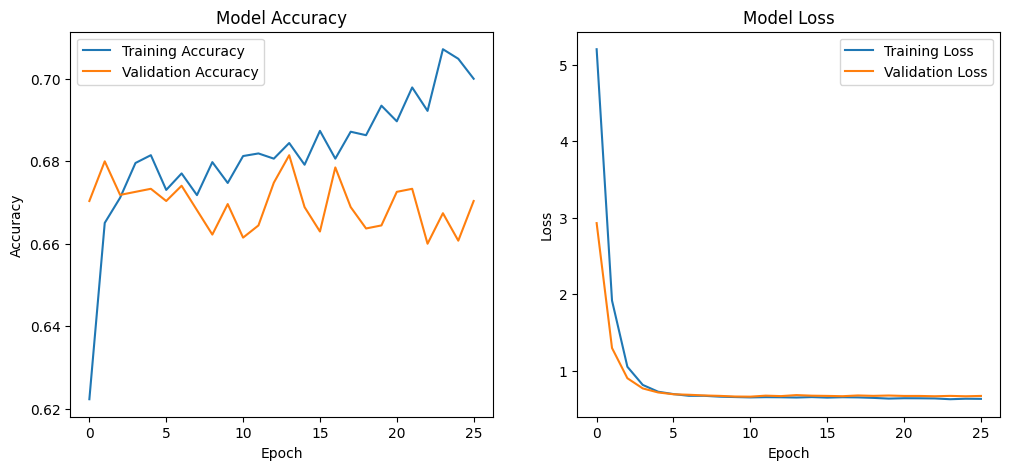

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **4. modele plus simple avec des courbes d'interessante (premier modele à tester sur streamlit)**

In [ ]:
model2 = Sequential()

model2.add(layers.Input((224, 224, 3)))
model2.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation="relu", kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model2.add(layers.MaxPool2D(pool_size=(2,2)))
model2.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", kernel_regularizer=l2(0.01)))
model2.add(layers.MaxPool2D(pool_size=(2,2)))
model2.add(layers.Dropout(0.2))
model2.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", kernel_regularizer=l2(0.01)))
model2.add(layers.MaxPool2D(pool_size=(2,2)))
model2.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", kernel_regularizer=l2(0.01)))
model2.add(layers.MaxPool2D(pool_size=(2,2)))
model2.add(layers.Dropout(0.2))

model2.add(layers.Flatten())

model2.add(layers.Dense(32, activation="relu", kernel_regularizer=l2(0.01)))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(16, activation="relu"))
model2.add(layers.Dense(8, activation="relu"))


model2.add(layers.Dense(1, activation="sigmoid"))

model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         589,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 687,969 (2.62 MB)

 Trainable params: 687,969 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'recall']
)

callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_recall', mode='max'),
    EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
]

history = model2.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5773 - loss: 3.9912 - recall: 0.2048

149/149 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.5776 - loss: 3.9817 - recall: 0.2041 - val_accuracy: 0.6637 - val_loss: 1.8044 - val_recall: 0.0000e+00
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6616 - loss: 1.6957 - recall: 0.0000e+00 - val_accuracy: 0.6637 - val_loss: 1.4258 - val_recall: 0.0000e+00
Epoch 3/30
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6633 - loss: 1.3543 - recall: 7.1461e-05

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6633 - loss: 1.3536 - recall: 8.7113e-05 - val_accuracy: 0.6644 - val_loss: 1.2150 - val_recall: 0.0044
Epoch 4/30
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6659 - loss: 1.1682 - recall: 0.0086

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6659 - loss: 1.1676 - recall: 0.0088 - val_accuracy: 0.6570 - val_loss: 1.0631 - val_recall: 0.2115
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6719 - loss: 1.0238 - recall: 0.0557 - val_accuracy: 0.6615 - val_loss: 0.9502 - val_recall: 0.1035
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6726 - loss: 0.9269 - recall: 0.0757 - val_accuracy: 0.6585 - val_loss: 0.8768 - val_recall: 0.1454
Epoch 7/30
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6702 - loss: 0.8528 - recall: 0.1172

149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6702 - loss: 0.8526 - recall: 0.1175 - val_accuracy: 0.6504 - val_loss: 0.8236 - val_recall: 0.2577
Epoch 8/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6706 - loss: 0.8068 - recall: 0.1447 - val_accuracy: 0.6637 - val_loss: 0.7900 - val_recall: 0.0000e+00
Epoch 9/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6752 - loss: 0.7710 - recall: 0.1166 - val_accuracy: 0.6630 - val_loss: 0.7442 - val_recall: 0.1123
Epoch 10/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6738 - loss: 0.7263 - recall: 0.1341 - val_accuracy: 0.6593 - val_loss: 0.7200 - val_recall: 0.1652
Epoch 11/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6763 - loss: 0.7052 - recall: 0.1655 - val_accuracy: 0.6667 - val_loss: 0.7024 - val_recall: 0.1718
Epoch 12/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6818 - loss: 0.6871 - recall: 0.1532 - val_accuracy: 0.6563 - val_loss: 0.6913 - val_recall: 0.2070
Epoch

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6819 - loss: 0.6648 - recall: 0.1923 - val_accuracy: 0.6659 - val_loss: 0.6732 - val_recall: 0.2775
Epoch 15/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6761 - loss: 0.6586 - recall: 0.1577 - val_accuracy: 0.6533 - val_loss: 0.6641 - val_recall: 0.2313
Epoch 16/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6754 - loss: 0.6535 - recall: 0.1925 - val_accuracy: 0.6593 - val_loss: 0.6606 - val_recall: 0.2621
Epoch 17/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6735 - loss: 0.6476 - recall: 0.1867 - val_accuracy: 0.6652 - val_loss: 0.6548 - val_recall: 0.1344
Epoch 18/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6713 - loss: 0.6490 - recall: 0.1453 - val_accuracy: 0.6600 - val_loss: 0.6523 - val_recall: 0.1828
Epoch 19/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6762 - loss: 0.6391 - recall: 0.1667 - val_accuracy: 0.6637 - val_loss: 0.6529 - val_recall: 0.2445
Epoch 20

149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6814 - loss: 0.6326 - recall: 0.1726 - val_accuracy: 0.6370 - val_loss: 0.6570 - val_recall: 0.3128
Epoch 27/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6820 - loss: 0.6295 - recall: 0.2318 - val_accuracy: 0.6393 - val_loss: 0.6508 - val_recall: 0.2599
Epoch 28/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6813 - loss: 0.6286 - recall: 0.2033 - val_accuracy: 0.6681 - val_loss: 0.6441 - val_recall: 0.1806
Epoch 29/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6794 - loss: 0.6323 - recall: 0.1748 - val_accuracy: 0.6630 - val_loss: 0.6420 - val_recall: 0.2335
Epoch 30/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6824 - loss: 0.6272 - recall: 0.2074 - val_accuracy: 0.6504 - val_loss: 0.6475 - val_recall: 0.2687


In [ ]:
test_loss, test_acc, test_recall = model2.evaluate(test_dataset)
print("Test accuracy:", test_acc)
print("Test recall:", test_recall)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6508 - loss: 0.6660 - recall: 0.2794
Test accuracy: 0.6473214030265808
Test recall: 0.2890625


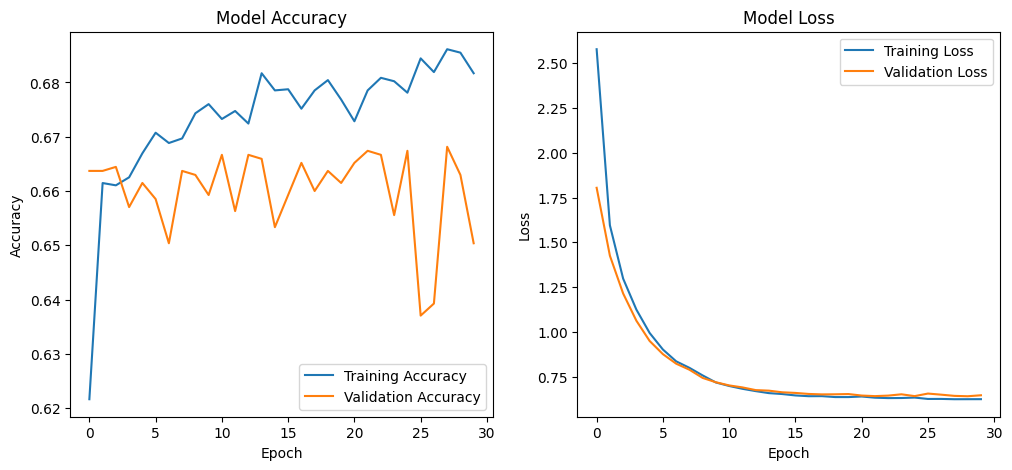

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **5.Test du model EfficientNetB3 et maison avec data processed**

1. model EfficientNetB3


In [ ]:
# Charger EfficientNetB5
base_model = EfficientNetB5(input_shape=(224,224,3), include_top=False, weights='imagenet')
base_model.trainable = False  # On gèle le modèle pré-entraîné au début

In [ ]:
# Ajout de couches supplémentaires pour améliorer la performance
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Réduction des dimensions
x = BatchNormalization()(x)  # ✅ Normalisation pour stabiliser l'apprentissage
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # ✅ Couche dense avec L2 Regularization ridge
x = Dropout(0.3)(x)  # ✅ Réduit le sur-apprentissage
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # ✅ Deuxième couche dense
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # ✅ Troisième couche dense
x = Dropout(0.3)(x)

output_layer = Dense(1, activation='sigmoid')(x)  # Classification binaire

# Création du modèle final
model_eff_test_data_preprocessed = Model(inputs=base_model.input, outputs=output_layer)

model_eff_test_data_preprocessed.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 29,735,160 (113.43 MB)

 Trainable params: 1,217,537 (4.64 MB)

 Non-trainable params: 28,517,623 (108.79 MB)

In [ ]:
model_eff_test_data_preprocessed.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'recall']
)

callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
]

history = model_eff_test_data_preprocessed.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.5963 - loss: 11.8490 - recall: 0.6039

98/98 ━━━━━━━━━━━━━━━━━━━━ 156s 890ms/step - accuracy: 0.5966 - loss: 11.8272 - recall: 0.6041 - val_accuracy: 0.5592 - val_loss: 5.8982 - val_recall: 0.3938
Epoch 2/30
97/98 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6874 - loss: 4.6866 - recall: 0.6471

98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6874 - loss: 4.6687 - recall: 0.6468 - val_accuracy: 0.6102 - val_loss: 2.5061 - val_recall: 0.2743
Epoch 3/30
97/98 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7043 - loss: 2.0450 - recall: 0.6535

98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7043 - loss: 2.0397 - recall: 0.6533 - val_accuracy: 0.6417 - val_loss: 1.4575 - val_recall: 0.0929
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7024 - loss: 1.2534 - recall: 0.6043 - val_accuracy: 0.6267 - val_loss: 1.0936 - val_recall: 0.1991
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7120 - loss: 0.9372 - recall: 0.5913 - val_accuracy: 0.6297 - val_loss: 0.9239 - val_recall: 0.1018
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7372 - loss: 0.7773 - recall: 0.6298 - val_accuracy: 0.5997 - val_loss: 0.8882 - val_recall: 0.2743
Epoch 7/30
97/98 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7281 - loss: 0.7195 - recall: 0.6253

98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7279 - loss: 0.7195 - recall: 0.6248 - val_accuracy: 0.6432 - val_loss: 0.8230 - val_recall: 0.1549
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7275 - loss: 0.6841 - recall: 0.6006 - val_accuracy: 0.6207 - val_loss: 0.7940 - val_recall: 0.1681
Epoch 9/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7249 - loss: 0.6659 - recall: 0.6054 - val_accuracy: 0.6117 - val_loss: 0.7885 - val_recall: 0.2743
Epoch 10/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7275 - loss: 0.6438 - recall: 0.6297 - val_accuracy: 0.5832 - val_loss: 0.7993 - val_recall: 0.2832
Epoch 11/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7258 - loss: 0.6287 - recall: 0.6232 - val_accuracy: 0.5802 - val_loss: 0.7792 - val_recall: 0.2434
Epoch 12/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7386 - loss: 0.6197 - recall: 0.6271 - val_accuracy: 0.6267 - val_loss: 0.7611 - val_recall: 0.1416
Epoch 13/30
98/98 

In [ ]:
test_loss, test_acc, test_recall = model_eff_test_data_preprocessed.evaluate(test_dataset)
print("Test accuracy:", test_acc)
print("Test recall:", test_recall)

11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6175 - loss: 0.7774 - recall: 0.2225
Test accuracy: 0.6212121248245239
Test recall: 0.2142857164144516


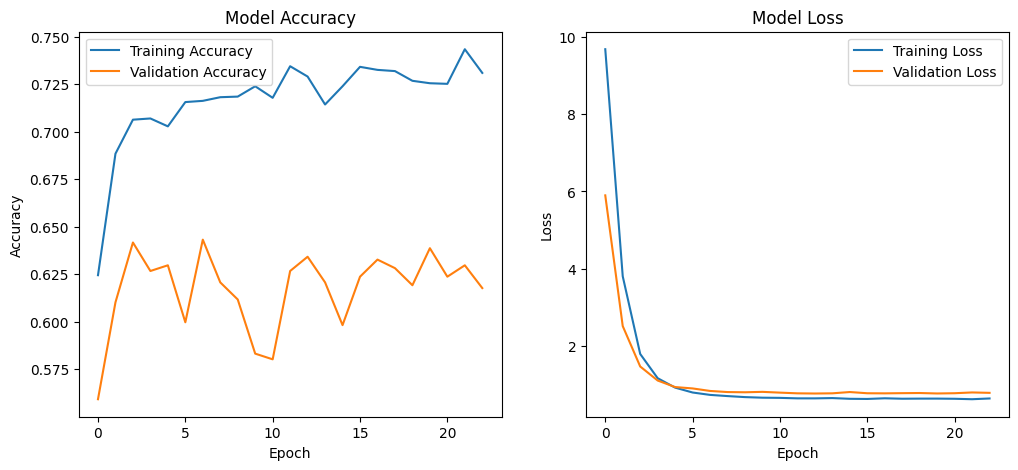

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

2. model maison avec preprocessed

In [ ]:
model_maison = Sequential()

model_maison.add(layers.Input((224, 224, 3)))
model_maison.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation="relu", kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model_maison.add(layers.MaxPool2D(pool_size=(2,2)))
model_maison.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", kernel_regularizer=l2(0.01)))
model_maison.add(layers.MaxPool2D(pool_size=(2,2)))
model_maison.add(layers.Dropout(0.2))
model_maison.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", kernel_regularizer=l2(0.01)))
model_maison.add(layers.MaxPool2D(pool_size=(2,2)))
model_maison.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", kernel_regularizer=l2(0.01)))
model_maison.add(layers.MaxPool2D(pool_size=(2,2)))
model_maison.add(layers.Dropout(0.2))

model_maison.add(layers.Flatten())

model_maison.add(layers.Dense(32, activation="relu", kernel_regularizer=l2(0.01)))
model_maison.add(layers.Dropout(0.2))
model_maison.add(layers.Dense(16, activation="relu"))
model_maison.add(layers.Dense(8, activation="relu"))


model_maison.add(layers.Dense(1, activation="sigmoid"))

model_maison.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │         589,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 687,969 (2.62 MB)

 Trainable params: 687,969 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_maison.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'recall']
)

callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_recall', mode='max'),
    EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
]

history = model_maison.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4980 - loss: 6.1181 - recall: 0.3817

98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.4980 - loss: 6.0901 - recall: 0.3827 - val_accuracy: 0.3388 - val_loss: 2.2271 - val_recall: 1.0000
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5158 - loss: 2.1238 - recall: 0.7045 - val_accuracy: 0.3418 - val_loss: 1.9231 - val_recall: 1.0000
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5211 - loss: 1.8594 - recall: 0.6735 - val_accuracy: 0.3538 - val_loss: 1.7315 - val_recall: 1.0000
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5245 - loss: 1.6850 - recall: 0.6744 - val_accuracy: 0.3388 - val_loss: 1.6012 - val_recall: 1.0000
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5316 - loss: 1.5499 - recall: 0.6982 - val_accuracy: 0.3493 - val_loss: 1.4812 - val_recall: 0.9956
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5464 - loss: 1.4347 - recall: 0.7268 - val_accuracy: 0.4003 - val_loss: 1.3751 - val_recall: 0.8717
Epoch 7/30
98/98 ━━━━━━━━

In [ ]:
test_loss, test_acc, test_recall = model_maison.evaluate(test_dataset)
print("Test accuracy:", test_acc)
print("Test recall:", test_recall)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.4005 - loss: 0.7238 - recall: 1.0000
Test accuracy: 0.38181817531585693
Test recall: 1.0


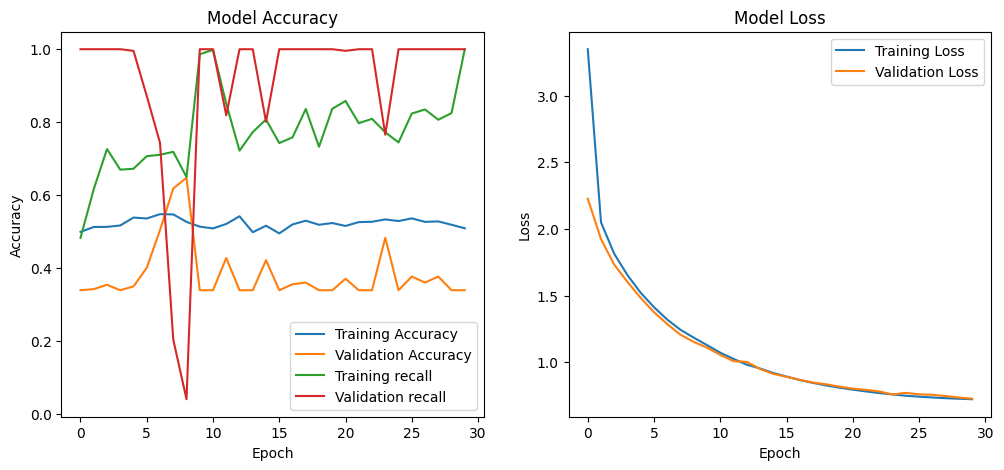

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['recall'], label='Training recall')
plt.plot(history.history['val_recall'], label='Validation recall')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


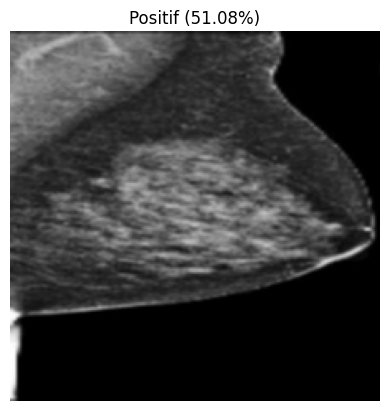

In [ ]:
predictImage("/content/data/preprocess_img/test/0/crp_1588_1603972171_png.rf.29f8eb427de2e92c2222298b7b497ad0.jpg", model_maison)

# **6. Test des models EfficientNetB3 etd maison avec data crop mais pas d'augmentation de la classe min**

In [ ]:
zip_path = "/content/preprocess_img_sans_aug.zip"  # Modifier avec votre chemin réel

import zipfile

# Définir le chemin du fichier ZIP et le dossier de destination
zip_path = "/content/preprocess_img_sans_aug.zip"
extract_path = "/content/data3"  # Dossier où extraire les fichiers

# Extraire le fichier ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction terminée !")

Extraction terminée !


In [ ]:
folder_path = "/content/data3/preprocess_img"

train_path = os.path.join(folder_path, "train")
valid_path = os.path.join(folder_path, "valid")
test_path = os.path.join(folder_path, "test")

In [ ]:
train_dataset = image_dataset_from_directory(
    train_path,
    labels="inferred",
    label_mode="binary",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123
)

validation_dataset = image_dataset_from_directory(
    valid_path,
    labels="inferred",
    label_mode="binary",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123
)

test_dataset = image_dataset_from_directory(
    test_path,
    labels="inferred",
    label_mode="binary",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123
)

Found 2333 files belonging to 2 classes.
Found 667 files belonging to 2 classes.
Found 330 files belonging to 2 classes.


In [ ]:
# Ajout de couches supplémentaires pour améliorer la performance
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Réduction des dimensions
x = BatchNormalization()(x)  # ✅ Normalisation pour stabiliser l'apprentissage
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # ✅ Couche dense avec L2 Regularization ridge
x = Dropout(0.3)(x)  # ✅ Réduit le sur-apprentissage
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # ✅ Deuxième couche dense
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # ✅ Troisième couche dense
x = Dropout(0.3)(x)

output_layer = Dense(1, activation='sigmoid')(x)  # Classification binaire

# Création du modèle final
model_eff_test_data_preprocessed = Model(inputs=base_model.input, outputs=output_layer)

model_eff_test_data_preprocessed.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 29,735,160 (113.43 MB)

 Trainable params: 1,217,537 (4.64 MB)

 Non-trainable params: 28,517,623 (108.79 MB)

In [ ]:
model_eff_test_data_preprocessed.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'recall']
)

callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
]

history = model_eff_test_data_preprocessed.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.6021 - loss: 12.5239 - recall: 0.3157

73/73 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.6022 - loss: 12.5025 - recall: 0.3154 - val_accuracy: 0.6552 - val_loss: 7.8151 - val_recall: 0.0088
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6302 - loss: 6.6767 - recall: 0.1936

73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6303 - loss: 6.6632 - recall: 0.1935 - val_accuracy: 0.6717 - val_loss: 3.9392 - val_recall: 0.0619
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6640 - loss: 3.3740 - recall: 0.1774 - val_accuracy: 0.6657 - val_loss: 2.2041 - val_recall: 0.1195
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.6700 - loss: 1.9518 - recall: 0.2120 - val_accuracy: 0.6657 - val_loss: 1.4593 - val_recall: 0.0398
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6704 - loss: 1.3528 - recall: 0.1463

73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6704 - loss: 1.3515 - recall: 0.1466 - val_accuracy: 0.6732 - val_loss: 1.1116 - val_recall: 0.0487
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6624 - loss: 1.0448 - recall: 0.1423 - val_accuracy: 0.6642 - val_loss: 0.9226 - val_recall: 0.0929
Epoch 7/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6645 - loss: 0.8862 - recall: 0.1507 - val_accuracy: 0.6642 - val_loss: 0.8180 - val_recall: 0.0177
Epoch 8/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6617 - loss: 0.8036 - recall: 0.0841 - val_accuracy: 0.6597 - val_loss: 0.7637 - val_recall: 0.0929
Epoch 9/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6678 - loss: 0.7442 - recall: 0.1190 - val_accuracy: 0.6702 - val_loss: 0.7388 - val_recall: 0.0841
Epoch 10/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6735 - loss: 0.7175 - recall: 0.1183 - val_accuracy: 0.6687 - val_loss: 0.7071 - val_recall: 0.0531
Epoch 11/30
73/73 ━━

In [ ]:
test_loss, test_acc, test_recall = model_eff_test_data_preprocessed.evaluate(test_dataset)
print("Test accuracy:", test_acc)
print("Test recall:", test_recall)

11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.6624 - loss: 0.7060 - recall: 0.2817
Test accuracy: 0.6545454263687134
Test recall: 0.2857142984867096


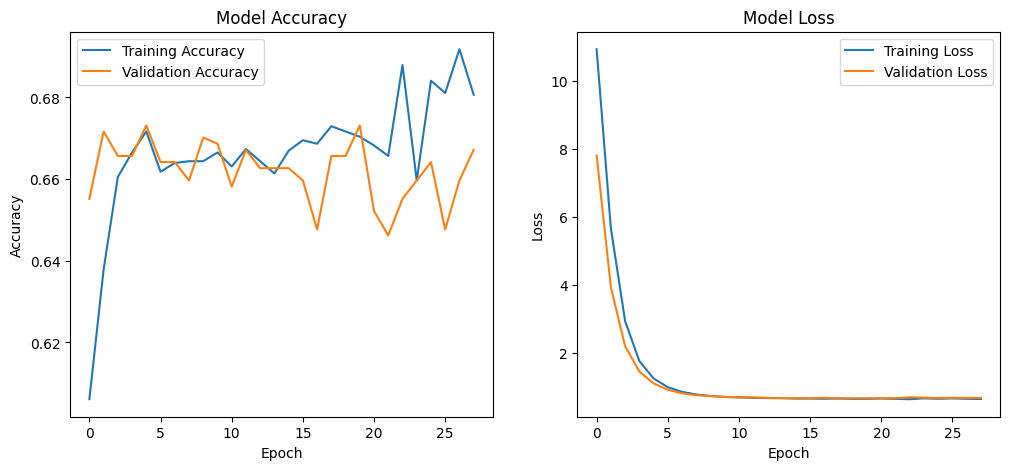

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

2.model maison


In [ ]:
model_maison = Sequential()
model_maison.add(layers.Input((224, 224, 3)))
model_maison.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation="relu", kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model_maison.add(layers.MaxPool2D(pool_size=(2,2)))
model_maison.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", kernel_regularizer=l2(0.01)))
model_maison.add(layers.MaxPool2D(pool_size=(2,2)))
model_maison.add(layers.Dropout(0.2))
model_maison.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", kernel_regularizer=l2(0.01)))
model_maison.add(layers.MaxPool2D(pool_size=(2,2)))
model_maison.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", kernel_regularizer=l2(0.01)))
model_maison.add(layers.MaxPool2D(pool_size=(2,2)))
model_maison.add(layers.Dropout(0.2))

model_maison.add(layers.Flatten())

model_maison.add(layers.Dense(32, activation="relu", kernel_regularizer=l2(0.01)))
model_maison.add(layers.Dropout(0.2))
model_maison.add(layers.Dense(16, activation="relu"))
model_maison.add(layers.Dense(8, activation="relu"))


model_maison.add(layers.Dense(1, activation="sigmoid"))

model_maison.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │         589,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 687,969 (2.62 MB)

 Trainable params: 687,969 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_maison.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'recall']
)

callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_recall', mode='max'),
    EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
]

history = model_maison.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6573 - loss: 0.6431 - recall: 0.0000e+00

73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.6573 - loss: 0.6431 - recall: 0.0000e+00 - val_accuracy: 0.6612 - val_loss: 0.6403 - val_recall: 0.0000e+00
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6638 - loss: 0.6387 - recall: 0.0000e+00 - val_accuracy: 0.6612 - val_loss: 0.6403 - val_recall: 0.0000e+00
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6602 - loss: 0.6410 - recall: 0.0000e+00 - val_accuracy: 0.6612 - val_loss: 0.6403 - val_recall: 0.0000e+00
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6439 - loss: 0.6515 - recall: 0.0000e+00 - val_accuracy: 0.6612 - val_loss: 0.6403 - val_recall: 0.0000e+00
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6623 - loss: 0.6396 - recall: 0.0000e+00 - val_accuracy: 0.6612 - val_loss: 0.6403 - val_recall: 0.0000e+00
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6671 - loss: 0.6364 - recall: 0.0000e+00 - val_accuracy: 0.6612 - val_loss: 0.64

In [ ]:
test_loss, test_acc, test_recall = model_maison.evaluate(test_dataset)
print("Test accuracy:", test_acc)
print("Test recall:", test_recall)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.5995 - loss: 0.6846 - recall: 0.0000e+00
Test accuracy: 0.6181818246841431
Test recall: 0.0


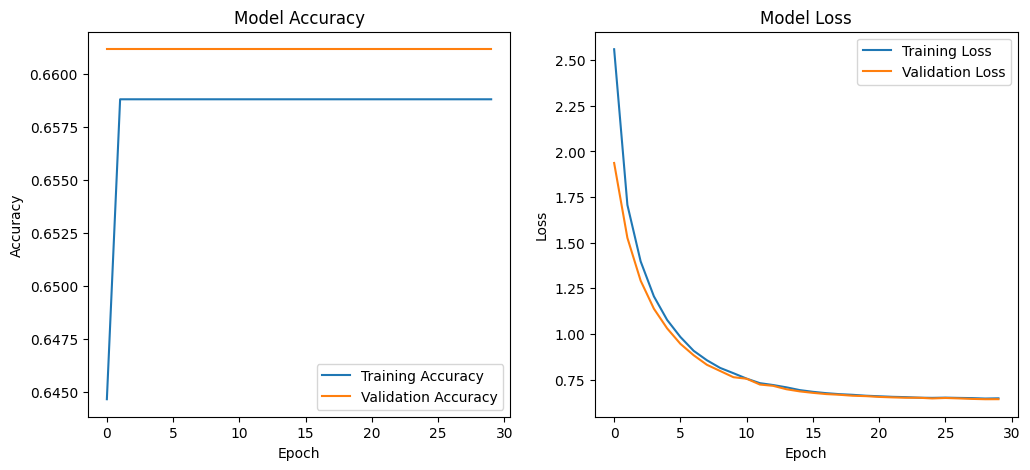

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **7. Test des models EfficientNetB3 et maison avec uniquement data crop**

In [ ]:
zip_path = "/content/cropped_img_no_prepros.zip"  # Modifier avec votre chemin réel

import zipfile

# Définir le chemin du fichier ZIP et le dossier de destination
zip_path = "/content/cropped_img_no_prepros.zip"
extract_path = "/content/data_crop"  # Dossier où extraire les fichiers

# Extraire le fichier ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction terminée !")

Extraction terminée !


In [ ]:
folder_path = "/content/data_crop/cropped_img_no_prepros"

train_path = os.path.join(folder_path, "train")
valid_path = os.path.join(folder_path, "valid")
test_path = os.path.join(folder_path, "test")

In [ ]:
train_dataset = image_dataset_from_directory(
    train_path,
    labels="inferred",
    label_mode="binary",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123
)

validation_dataset = image_dataset_from_directory(
    valid_path,
    labels="inferred",
    label_mode="binary",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123
)

test_dataset = image_dataset_from_directory(
    test_path,
    labels="inferred",
    label_mode="binary",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123
)

Found 2335 files belonging to 2 classes.
Found 668 files belonging to 2 classes.
Found 331 files belonging to 2 classes.


In [ ]:
# Ajout de couches supplémentaires pour améliorer la performance
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Réduction des dimensions
x = BatchNormalization()(x)  # ✅ Normalisation pour stabiliser l'apprentissage
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # ✅ Couche dense avec L2 Regularization ridge
x = Dropout(0.3)(x)  # ✅ Réduit le sur-apprentissage
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # ✅ Deuxième couche dense
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # ✅ Troisième couche dense
x = Dropout(0.3)(x)

output_layer = Dense(1, activation='sigmoid')(x)  # Classification binaire

# Création du modèle final
model_eff_test_data_preprocessed = Model(inputs=base_model.input, outputs=output_layer)

model_eff_test_data_preprocessed.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 29,735,160 (113.43 MB)

 Trainable params: 1,217,537 (4.64 MB)

 Non-trainable params: 28,517,623 (108.79 MB)

In [ ]:
model_eff_test_data_preprocessed.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'recall']
)

callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
]

history = model_eff_test_data_preprocessed.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.5937 - loss: 12.3667 - recall: 0.2776

73/73 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.5938 - loss: 12.3421 - recall: 0.2775 - val_accuracy: 0.6602 - val_loss: 7.0965 - val_recall: 0.0000e+00
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6517 - loss: 5.8952 - recall: 0.1959 - val_accuracy: 0.6602 - val_loss: 3.2828 - val_recall: 0.0176
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6806 - loss: 2.7769 - recall: 0.1165

73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.6803 - loss: 2.7720 - recall: 0.1168 - val_accuracy: 0.6662 - val_loss: 1.8093 - val_recall: 0.0485
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6699 - loss: 1.5998 - recall: 0.0982 - val_accuracy: 0.6557 - val_loss: 1.2288 - val_recall: 0.0529
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6708 - loss: 1.1308 - recall: 0.1064 - val_accuracy: 0.6482 - val_loss: 0.9817 - val_recall: 0.1894
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6832 - loss: 0.9117 - recall: 0.1406 - val_accuracy: 0.6617 - val_loss: 0.8501 - val_recall: 0.0441
Epoch 7/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6711 - loss: 0.8089 - recall: 0.0416 - val_accuracy: 0.6587 - val_loss: 0.7691 - val_recall: 0.0837
Epoch 8/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6797 - loss: 0.7454 - recall: 0.1257

73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6795 - loss: 0.7454 - recall: 0.1260 - val_accuracy: 0.6707 - val_loss: 0.7320 - val_recall: 0.0837
Epoch 9/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6701 - loss: 0.7083 - recall: 0.0662 - val_accuracy: 0.6662 - val_loss: 0.7121 - val_recall: 0.1145
Epoch 10/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6794 - loss: 0.6935 - recall: 0.0937 - val_accuracy: 0.6662 - val_loss: 0.6913 - val_recall: 0.0529
Epoch 11/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6732 - loss: 0.6773 - recall: 0.0838 - val_accuracy: 0.6617 - val_loss: 0.6849 - val_recall: 0.1278
Epoch 12/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6748 - loss: 0.6737 - recall: 0.0931 - val_accuracy: 0.6617 - val_loss: 0.6872 - val_recall: 0.1013
Epoch 13/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6766 - loss: 0.6730 - recall: 0.1036 - val_accuracy: 0.6602 - val_loss: 0.6764 - val_recall: 0.1189
Epoch 14/30
73/73

73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6818 - loss: 0.6395 - recall: 0.1387 - val_accuracy: 0.6766 - val_loss: 0.6871 - val_recall: 0.1718
Epoch 24/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6744 - loss: 0.6571 - recall: 0.1174 - val_accuracy: 0.6617 - val_loss: 0.6883 - val_recall: 0.2687
Epoch 25/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6823 - loss: 0.6632 - recall: 0.2097 - val_accuracy: 0.6632 - val_loss: 0.6820 - val_recall: 0.1233
Epoch 26/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6677 - loss: 0.6581 - recall: 0.1350 - val_accuracy: 0.6692 - val_loss: 0.6871 - val_recall: 0.1233
Epoch 27/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6888 - loss: 0.6481 - recall: 0.1831 - val_accuracy: 0.6722 - val_loss: 0.6838 - val_recall: 0.0793
Epoch 27: early stopping


In [ ]:
test_loss, test_acc, test_recall = model_eff_test_data_preprocessed.evaluate(test_dataset)
print("Test accuracy:", test_acc)
print("Test recall:", test_recall)

11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.6511 - loss: 0.7018 - recall: 0.1076
Test accuracy: 0.6465256810188293
Test recall: 0.11811023950576782


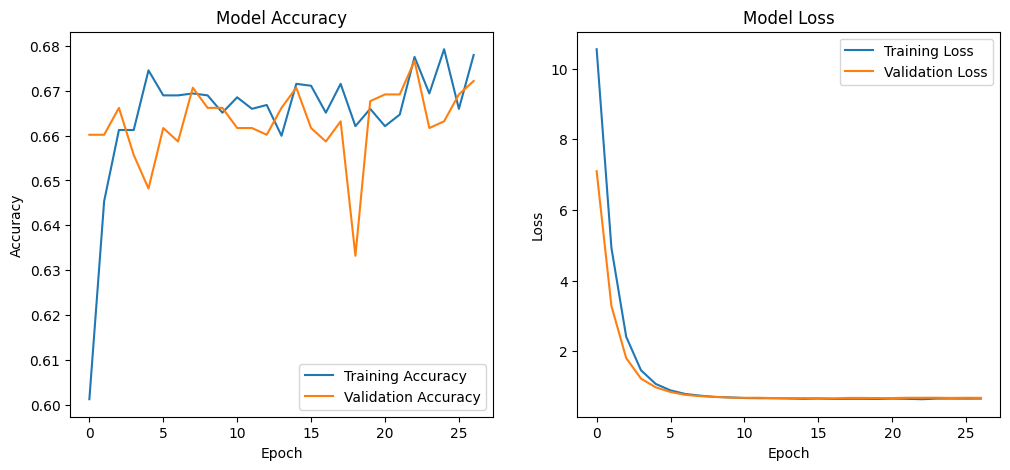

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

2. model maison


In [ ]:
model_maison = Sequential()
model_maison.add(layers.Input((224, 224, 3)))
model_maison.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation="relu", kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model_maison.add(layers.MaxPool2D(pool_size=(2,2)))
model_maison.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", kernel_regularizer=l2(0.01)))
model_maison.add(layers.MaxPool2D(pool_size=(2,2)))
model_maison.add(layers.Dropout(0.2))
model_maison.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", kernel_regularizer=l2(0.01)))
model_maison.add(layers.MaxPool2D(pool_size=(2,2)))
model_maison.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", kernel_regularizer=l2(0.01)))
model_maison.add(layers.MaxPool2D(pool_size=(2,2)))
model_maison.add(layers.Dropout(0.2))

model_maison.add(layers.Flatten())

model_maison.add(layers.Dense(32, activation="relu", kernel_regularizer=l2(0.01)))
model_maison.add(layers.Dropout(0.2))
model_maison.add(layers.Dense(16, activation="relu"))
model_maison.add(layers.Dense(8, activation="relu"))


model_maison.add(layers.Dense(1, activation="sigmoid"))

model_maison.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │         589,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 687,969 (2.62 MB)

 Trainable params: 687,969 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_maison.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'recall']
)

callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_recall', mode='max'),
    EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
]

history = model_maison.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5521 - loss: 9.5087 - recall: 0.2960

73/73 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - accuracy: 0.5525 - loss: 9.4436 - recall: 0.2951 - val_accuracy: 0.6602 - val_loss: 2.4936 - val_recall: 0.0000e+00
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6716 - loss: 2.3887 - recall: 0.0000e+00 - val_accuracy: 0.6602 - val_loss: 2.1866 - val_recall: 0.0000e+00
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6686 - loss: 2.1174 - recall: 0.0000e+00 - val_accuracy: 0.6602 - val_loss: 1.9656 - val_recall: 0.0000e+00
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6709 - loss: 1.9186 - recall: 0.0000e+00 - val_accuracy: 0.6602 - val_loss: 1.8067 - val_recall: 0.0000e+00
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6650 - loss: 1.7739 - recall: 0.0000e+00 - val_accuracy: 0.6602 - val_loss: 1.6782 - val_recall: 0.0000e+00
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6576 - loss: 1.6536 - recall: 0.0000e+00 - val_accuracy: 0.6602 - val_loss: 1.5818 

In [ ]:
test_loss, test_acc, test_recall = model_maison.evaluate(test_dataset)
print("Test accuracy:", test_acc)
print("Test recall:", test_recall)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.6135 - loss: 0.8054 - recall: 0.0000e+00
Test accuracy: 0.616314172744751
Test recall: 0.0


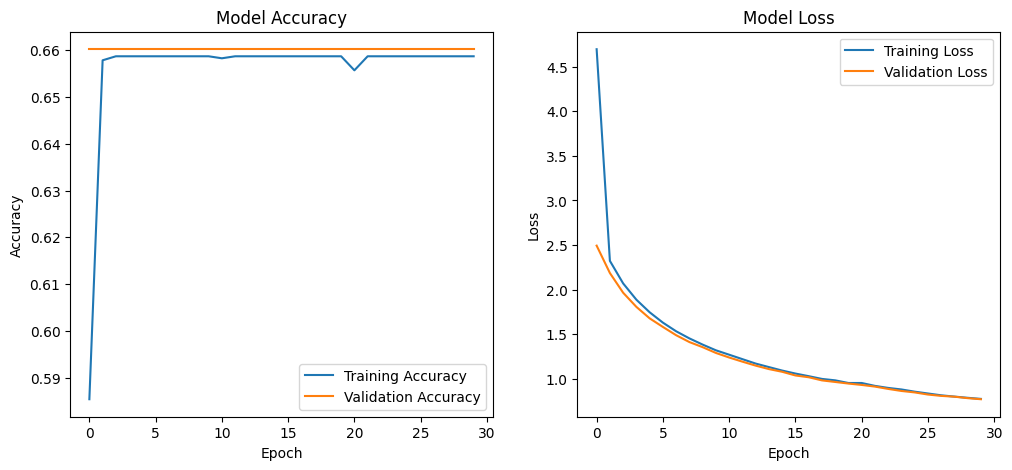

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **Autre approche en s'inspirant d'un notebook**

In [ ]:
zip_path = "/content/Deep_learning.zip"  # Modifier avec votre chemin réel

import zipfile

# Définir le chemin du fichier ZIP et le dossier de destination
zip_path = "/content/Deep_learning.zip"
extract_path = "/content/data"  # Dossier où extraire les fichiers

# Extraire le fichier ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction terminée !")

Extraction terminée !


In [ ]:
# Image size for resizing
img_size = 224
# Labels for image categories
labels = ['0', '1']

def loading_data(data_dir):
    data = []
    labels_list = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
            if img_arr is not None:  # Check if the image was read successfully
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Resize image
                data.append(resized_arr)
                labels_list.append(class_num)
            else:
                print(f"Warning: Unable to read image {img_path}")

    return np.array(data), np.array(labels_list)

# Load data for training, testing, and validation
train_data, train_labels = loading_data('/content/data/Deep_learning/train')
test_data, test_labels = loading_data('/content/data/Deep_learning/test')
valid_data, valid_labels = loading_data('/content/data/Deep_learning/valid')


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.


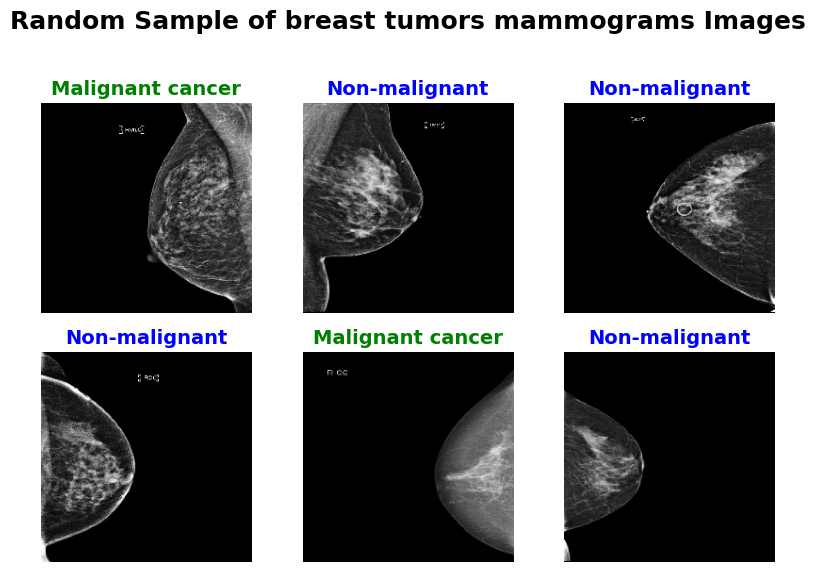

In [ ]:
random_indices = np.random.choice(len(train_data), 6, replace=False)

# Set up the figure
plt.figure(figsize=(8, 8))

# Plot the images
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_data[idx], cmap='gray')  # Use 'gray' colormap for medical images
    plt.title('Non-malignant' if train_labels[idx] == 0 else 'Malignant cancer', fontsize=14, fontweight='bold', color='blue' if train_labels[idx] == 0 else 'green')
    plt.axis('off')

# Add a main title
plt.suptitle("Random Sample of breast tumors mammograms Images", fontsize=18, fontweight='bold', y=1.02)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [ ]:
# Normalize the data
X_train = np.array(train_data) / 255
X_test = np.array(test_data) / 255
X_valid = np.array(valid_data) / 255

In [ ]:
img_size = 224

# Reshape the grayscale images to 128x128x1
X_train = X_train.reshape(-1, img_size, img_size, 1)
X_test = X_test.reshape(-1, img_size, img_size, 1)
X_valid = X_valid.reshape(-1, img_size, img_size, 1)

# Convert grayscale to RGB by duplicating the single channel 3 times
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)
X_valid = np.repeat(X_valid, 3, axis=-1)

# Convert labels to numpy arrays
y_train = np.array(train_labels)
y_test = np.array(test_labels)
y_valid = np.array(valid_labels)

print(X_train.shape)  # This should now show (num_samples, 128, 128, 3)
print(X_test.shape)
print(X_valid.shape)

(2372, 224, 224, 3)
(336, 224, 224, 3)
(675, 224, 224, 3)


In [ ]:
# Concatenate training and validation sets
X_train = np.concatenate((X_train, X_valid), axis=0)
y_train = np.concatenate((y_train, y_valid), axis=0)

val_size = 0.2

# Split the data
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=val_size, random_state=21)

# Check the shapes
print("Training data shape:", X_train_split.shape)
print("Validation data shape:", X_val_split.shape)
print("Training labels shape:", y_train_split.shape)
print("Validation labels shape:", y_val_split.shape)

Training data shape: (2977, 224, 224, 3)
Validation data shape: (745, 224, 224, 3)
Training labels shape: (2977,)
Validation labels shape: (745,)


In [ ]:
# Performing Data Augmentation
data_generator = ImageDataGenerator(
                    rotation_range = 30,
                    zoom_range = 0.2,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    horizontal_flip = True,
                    shear_range=0.2,
                    fill_mode='nearest',
                 )


data_generator.fit(X_train)

In [ ]:
#Define the input shape
input_shape = (224, 224, 3)  # Directly using RGB input

# Load MobileNet with pre-trained weights, specifying the input shape and without the top classification layers
mobilenet_base = EfficientNetB4(input_shape=input_shape, include_top=False, weights='imagenet')

# Add Global Average Pooling to reduce dimensionality
x = mobilenet_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
# x = Dense(96,activation='relu', kernel_regularizer=l2(0.05))(x)
x = Dense(96, activation='relu', kernel_regularizer=l2(0.1))(x)  # Increased regularization
x = BatchNormalization()(x)  # Added batch normalization
x = Dropout(0.5)(x)
# Add the final Dense layer for binary classification
output_layer = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.1))(x)
# output_layer = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.05))(x)

# Create the final model
model = Model(inputs=mobilenet_base.input, outputs=output_layer)

# Compile the model
# optimizer = Adam(learning_rate=0.001)
optimizer = Adam(learning_rate=0.0001)  # Reduced learning rate

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'recall'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Show model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_6 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_3           │ (None, 224, 224, 3)    │              7 │ rescaling_6[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_7 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_7[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 17,846,432 (68.08 MB)

 Trainable params: 17,721,033 (67.60 MB)

 Non-trainable params: 125,399 (489.84 KB)

In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

history = model.fit(X_train_split, y_train_split, epochs=100,
          validation_data=data_generator.flow(X_val_split, y_val_split),
          batch_size=64, class_weight=class_weights)

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5228 - loss: 18.7598 - recall: 0.5413   

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.5229 - loss: 18.7482 - recall: 0.5416 - val_accuracy: 0.6013 - val_loss: 16.6939 - val_recall: 0.1784
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 804ms/step - accuracy: 0.5756 - loss: 16.3336 - recall: 0.6606 - val_accuracy: 0.3221 - val_loss: 14.7122 - val_recall: 0.9834
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 793ms/step - accuracy: 0.6183 - loss: 14.2387 - recall: 0.6935 - val_accuracy: 0.3570 - val_loss: 12.8488 - val_recall: 0.9253
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 786ms/step - accuracy: 0.6449 - loss: 12.4088 - recall: 0.7363 - val_accuracy: 0.4685 - val_loss: 11.2548 - val_recall: 0.6058
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 788ms/step - accuracy: 0.6672 - loss: 10.8483 - recall: 0.7749 - val_accuracy: 0.3597 - val_loss: 9.9505 - val_recall: 0.9585
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 784ms/step - accuracy: 0.7231 - loss: 9.4247 - recall: 0.8405 - val_accuracy: 0.4470 - val_loss: 8.7367 - val_recall: 0.58